In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
%matplotlib inline
import torch
from deepseries.models import WaveNet, init
from deepseries.dataset import Property, TimeSeries, SeriesFrame, Seq2SeqDataLoader
from deepseries.train import Learner
from torch.optim import Adam
from torch import nn
import matplotlib as mpl
from sklearn.metrics import mean_absolute_error

info = pd.read_excel("./data/info.xlsx")
recored = info.set_index("contributor_id")['huangzf']
info = pd.read_excel("./data/info.xlsx").set_index("contributor_id")[['pjt_name', 'pjt_type']]

In [2]:
power = pd.read_csv('./data/df.csv', parse_dates=['data_time'])[['data_time', 'cid', 'value']]
power = power.set_index("data_time").groupby("cid").resample("1H").sum().reset_index()
power = power.pivot(index='cid', columns='data_time', values='value')
power = power.apply(np.log1p).iloc[:, 1000:]

In [3]:
is_zero = power.values == 0
is_nan = power.isnull().values
is_valid = ~is_zero & ~is_nan

xy = np.ma.masked_array(power.values, mask=~is_valid)

series_mu = xy.mean(axis=1).data.reshape(-1, 1)
series_std = xy.std(axis=1).data.reshape(-1, 1)
xy = (xy - series_mu) / series_std
xy = xy.filled(0.)

xy = np.expand_dims(xy, 1).astype('float32')

N_TEST = 24 * 15
N_VALID = 24 * 2
DROP_ZERO = True
DEC_LEN = 24 * 2
ENC_LEN = 24 * 7
time_free_space = 24

In [4]:
def n_lag(series, n):
    lag = np.zeros_like(series)
    lag[:, :, n:] = series[:, :, :-n]
    return lag

x_lag7 = n_lag(xy, 7)
x_lag14 = n_lag(xy, 14)

x_is_valid = np.expand_dims(is_valid, 1)

x_num_features = np.concatenate([x_lag7, x_lag14], axis=1).astype("float32")

In [5]:
def periodic_feature(x, T):
    psin = np.sin(x * np.pi * 2 / T)
    pcos = np.cos(x * np.pi * 2 / T)
    return np.stack([psin, pcos], axis=0)


xy_weekday = np.repeat(
    np.expand_dims(
        periodic_feature(power.columns.weekday.values, 7), axis=0), xy.shape[0], axis=0)

xy_hour = np.repeat(
    np.expand_dims(
        periodic_feature(power.columns.hour.values, 24), axis=0), xy.shape[0], axis=0)

xy_month = np.repeat(
    np.expand_dims(
        periodic_feature(power.columns.month.values, 12), axis=0), xy.shape[0], axis=0)

xy_num_features = np.concatenate([
    xy_weekday,
    xy_hour,
    xy_month,
    x_is_valid
], axis=1).astype('float32')

In [6]:
class ForwardSpliter:
    
    def split(self, time_idx, enc_len, dec_len, valid_size):
        if valid_size < 1:
            valid_size = int(np.floor(len(time_idx) * valid_size))
        valid_idx = time_idx[-(valid_size+enc_len):]
        train_idx = time_idx[:-valid_size]
        return train_idx, valid_idx
    
spliter = ForwardSpliter()
train_idx, valid_idx = spliter.split(np.arange(xy.shape[2]), ENC_LEN, DEC_LEN, N_TEST+N_VALID)
valid_idx, test_idx = spliter.split(valid_idx, ENC_LEN, DEC_LEN, N_TEST)

train_xy = TimeSeries(xy[:, :, train_idx])
valid_xy = TimeSeries(xy[:, :, valid_idx])

train_xy_features = TimeSeries(xy_num_features[:, :, train_idx])
valid_xy_features = TimeSeries(xy_num_features[:, :, valid_idx])

train_x_features = TimeSeries(x_num_features[:, :, train_idx])
valid_x_features = TimeSeries(x_num_features[:, :, valid_idx])

train_frame = SeriesFrame(train_xy, batch_size=4, enc_lens=ENC_LEN, dec_lens=DEC_LEN, 
                          enc_num_feats=[train_xy_features, train_x_features], dec_num_feats=[train_xy_features])
valid_frame = SeriesFrame(valid_xy, batch_size=4, enc_lens=ENC_LEN, dec_lens=DEC_LEN,
                         enc_num_feats=[valid_xy_features, valid_x_features], dec_num_feats=[valid_xy_features])

test_xy = xy[:, :, test_idx]
test_xf = np.concatenate([xy_num_features[:, :, test_idx], x_num_features[:, :, test_idx]], axis=1)
test_yf = xy_num_features[:, :, test_idx]

In [7]:
train_frame = Seq2SeqDataLoader(train_xy, batch_size=4, enc_lens=ENC_LEN, dec_lens=DEC_LEN, use_cuda=True, mode='train', time_free_space=24,
                          enc_num_feats=[train_xy_features, train_x_features], dec_num_feats=[train_xy_features])
valid_frame = Seq2SeqDataLoader(valid_xy, batch_size=32, enc_lens=ENC_LEN, dec_lens=DEC_LEN, use_cuda=True, mode='train', time_free_space=0,
                         time_interval=48, enc_num_feats=[valid_xy_features, valid_x_features], dec_num_feats=[valid_xy_features])

In [ ]:
model = WaveNet(enc_numerical=9, dec_numerical=7, dilations=[2 ** i for i in range(5)] * 3, 
                kernels_size=[2 for i in range(5)] * 3, dropout=0.5)
opt = Adam(model.parameters(), 0.005)
loss_fn = nn.MSELoss()
model.cuda()
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, 64, 0.001)
learner = Learner(model, opt, loss_fn, './power_env', log_interval=20, lr_scheduler=lr_scheduler)
learner.fit(500, train_frame, valid_frame, patient=32, start_save=1, early_stopping=False)

start training >>>>>>>>>>>  see log: tensorboard --logdir ./power_env\logs


In [9]:
test_xy = torch.as_tensor(xy[:, :, test_idx]).cuda()
test_xf = torch.as_tensor(np.concatenate([xy_num_features[:, :, test_idx], x_num_features[:, :, test_idx]], axis=1)).cuda()
test_yf = torch.as_tensor(xy_num_features[:, :, test_idx]).cuda()

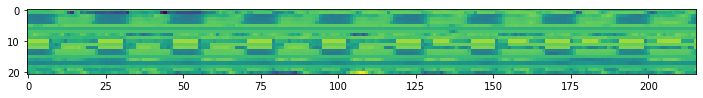

In [25]:
plt.figure(figsize=(12, 36))
plt.imshow(pd.DataFrame(valid_xy.values.squeeze()))

In [23]:
test_xy

tensor([[[ 0.3305,  0.4383,  0.3461,  ...,  0.5340,  0.6002,  0.4078]],

        [[-2.6973, -2.7202, -2.6523,  ...,  0.6935,  0.7123,  0.7643]],

        [[-1.1154, -1.3713, -1.5728,  ...,  0.5576, -0.1046, -0.5182]],

        ...,

        [[ 0.0293, -0.0140,  0.0275,  ...,  0.0492,  0.0315,  0.0549]],

        [[ 0.4669,  0.4652,  0.4997,  ..., -0.0574,  0.1168,  0.3724]],

        [[-1.8740, -1.2810, -0.6313,  ...,  1.1169,  1.1122,  0.6895]]],
       device='cuda:0')

TypeError: Image data of dtype object cannot be converted to float

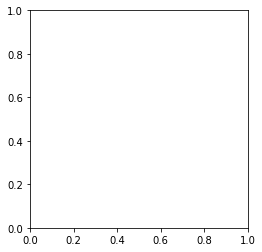

In [24]:
plt.imshow(pd.DataFrame(test_xy.squeeze()))

In [10]:
def plot(x_true, y_true, y_pred):
    enc_ticks = np.arange(x_true.shape[1])
    dec_ticks = np.arange(y_pred.shape[1]) + x_true.shape[1]
    for idx, name in enumerate(power.index):
        plt.figure(figsize=(12, 3))
        plt.plot(enc_ticks, x_true[idx])
        plt.plot(dec_ticks, y_pred[idx], label='pred')
        plt.plot(dec_ticks, y_true[idx], label='true')
        plt.title(name)
        plt.legend()

def wmape(y_hat, y):
    scores = []
    for day in range(int(y.shape[0] / 24)):
        scores.append(np.abs(y[day*24: (day+1)*24] - y_hat[day*24: (day+1)*24]).sum() / np.sum(y[day*24: (day+1)*24]))
    return scores

def metric(y_true, y_pred):
    scores = {}
    for idx, name in enumerate(power.index):
        scores[name] = wmape(y_pred[idx], y_true[idx])
    return pd.DataFrame(scores)

def predict(learner, xy, x_feats, y_feats, epoch):
    learner.load(rf"C:\Users\evilp\project\Deep-Time-Series-Prediction\power_env\checkpoints\model-epoch-{epoch}.pkl")
    learner.model.eval()
    learner.model.cuda()
    preds = []
    days = int(xy.shape[2] / 24 - ENC_LEN / 24 - DEC_LEN/24 + 1)
    for day in range(days):
        step = day * 24
#         enc_start = day
#         enc_end = (step+ENC_LEN) / 24
#         dec_start = enc_end
#         dec_end = (step+ENC_LEN+DEC_LEN) / 24
#         print(f"start {enc_start}, end {int(dec_end)}" )
        step_pred = model(
            xy[:, :, step: step+ENC_LEN], 
            enc_num=x_feats[:, :, step: step+ENC_LEN],
            dec_num=y_feats[:, :, step+ENC_LEN: step+ENC_LEN+DEC_LEN], dec_len=DEC_LEN).cpu().detach().numpy()
        if step == 0:
            preds.append(step_pred)
        else:
            preds.append(step_pred[:, :, -24:])
    preds = np.concatenate(preds, axis=2)
    preds = np.expm1(preds.squeeze() * series_std + series_mu)
    
    x_true = np.expm1(xy[:, :, :ENC_LEN].cpu().numpy().squeeze() * series_std + series_mu)
    y_true = np.expm1(xy[:, :, ENC_LEN:].cpu().numpy().squeeze() * series_std + series_mu)
    
    return x_true, y_true, preds

In [11]:
x_true, y_true, y_pred  = predict(learner, test_xy, test_xf, test_yf, 227)
scores = pd.DataFrame([metric(y_true, y_pred).mean().rename("wave"), recored.rename("normal")]).T.dropna()

In [12]:
y_true.mean()

18304.45699606043

In [13]:
y_pred.mean()

14759.158597176696

In [14]:
scores.merge(info, left_index=True, right_index=True).mean()

wave      0.352079
normal    1.205489
dtype: float64

In [19]:
scores.merge(info, left_index=True, right_index=True)

,wave,normal,pjt_name,pjt_type
91E0B6DC00B91783E0530BC8100A0E30,0.225981,1.393969,泸州长江机械,工业
91E0B6DC00BC1783E0530BC8100A0E30,0.342035,0.425888,嘉华水泥,工业
91E0B6DC00C91783E0530BC8100A0E30,0.340848,0.131399,成都华翊龙房地产开发有限公司,商业
91E0B6DC00CB1783E0530BC8100A0E30,0.430636,0.079528,鹏瑞利,商业
91E0B6DC00DA1783E0530BC8100A0E30,0.461721,0.143502,福来房地产,商业
91E0B6DC00E31783E0530BC8100A0E30,0.301207,3.283425,益海嘉里（成都）,工业
91E0B6DC00E91783E0530BC8100A0E30,0.035221,0.042607,合盛硅业（泸州）,工业
91E0B6DC01081783E0530BC8100A0E30,0.309044,0.848073,迅源纸业,工业
91E0B6DC01171783E0530BC8100A0E30,0.106425,0.192005,攀枝花煤业（集团）有限责任公司2832505365,工业
91E0B6DC01221783E0530BC8100A0E30,0.237057,0.811921,兴发铝业(成都),工业


C:\Users\evilp\AppData\Local\Continuum\anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


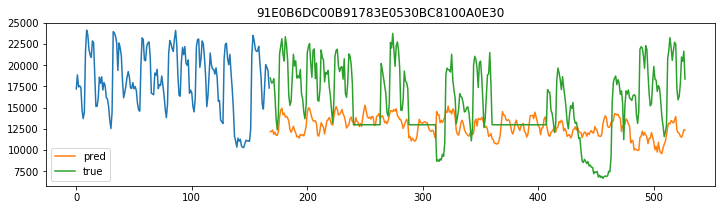

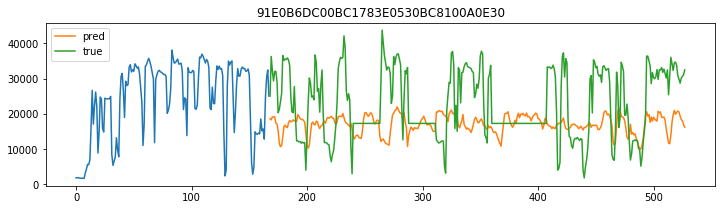

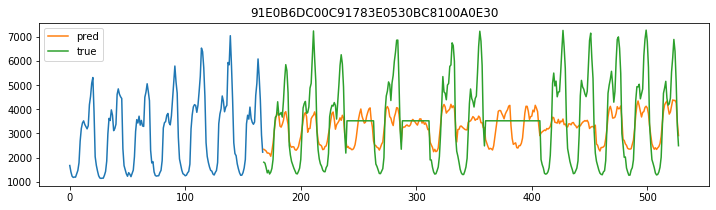

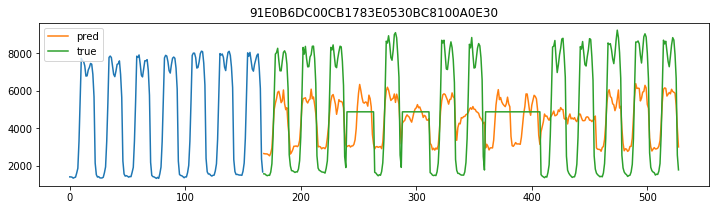

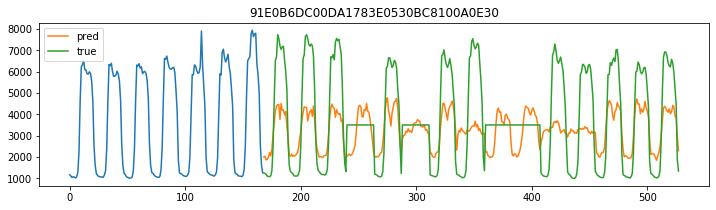

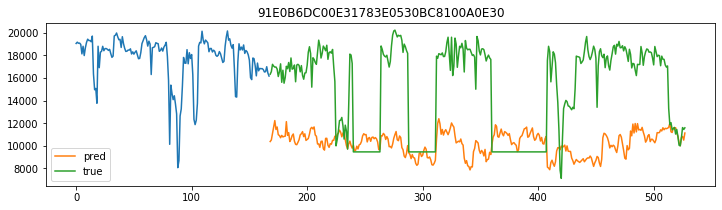

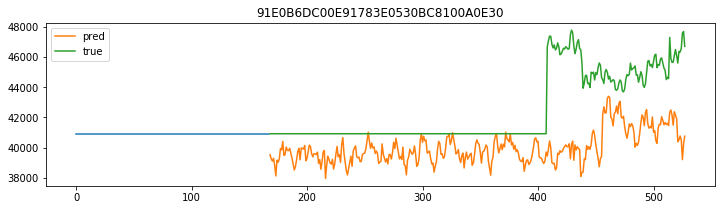

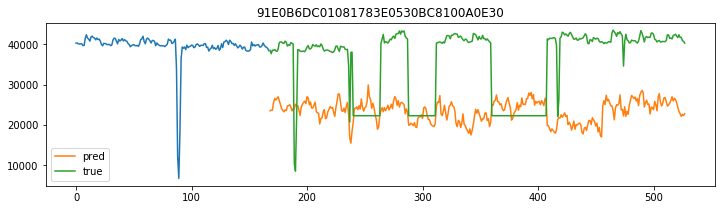

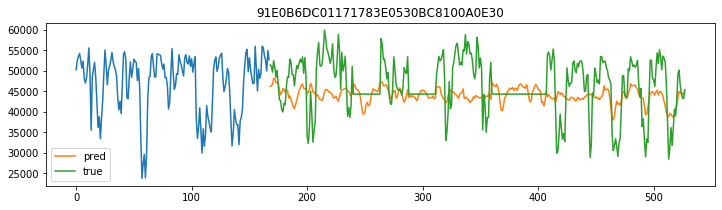

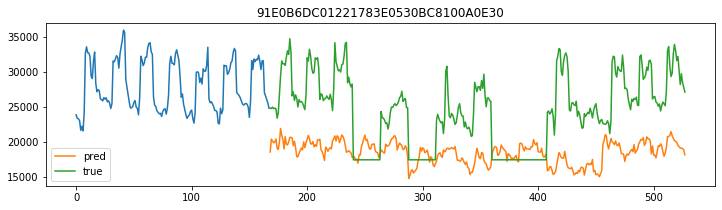

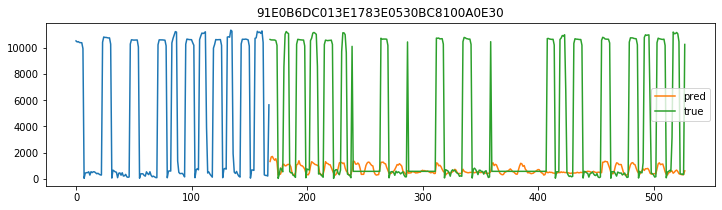

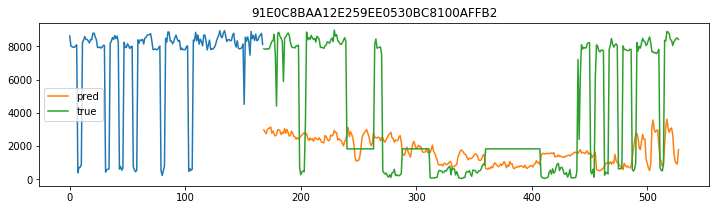

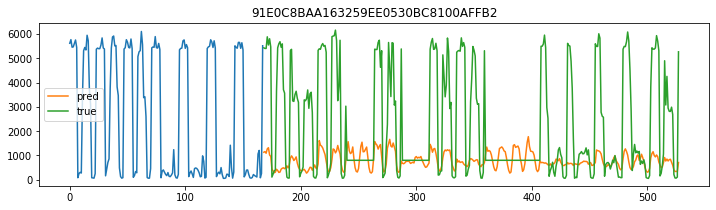

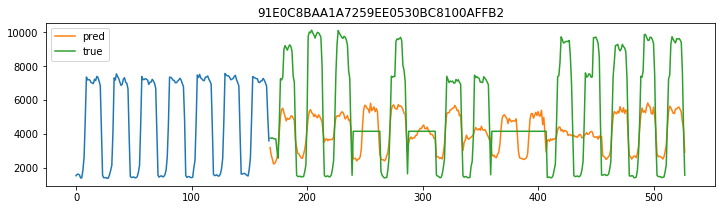

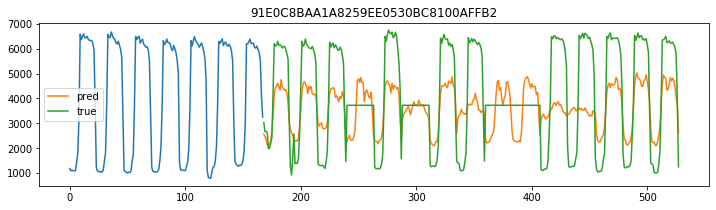

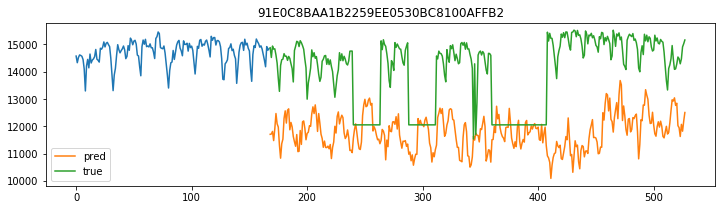

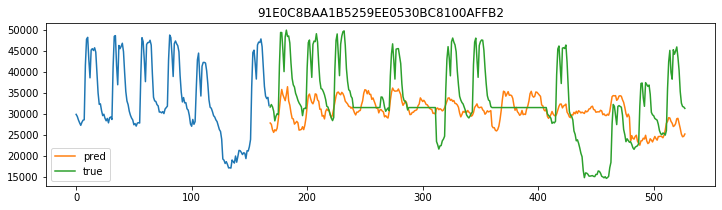

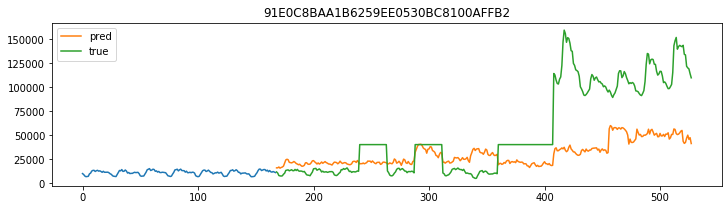

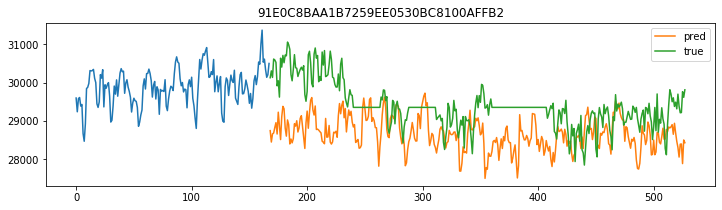

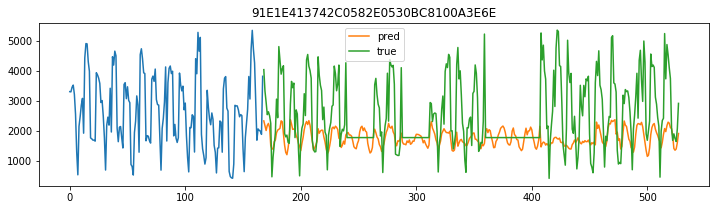

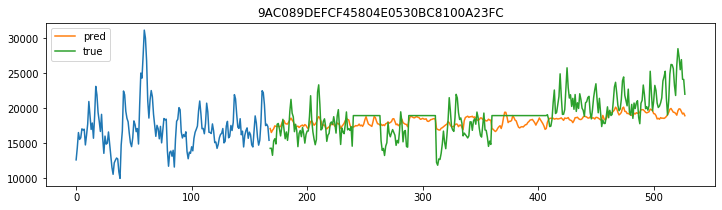

In [15]:
plot(x_true, y_true, y_pred)

In [20]:
x_true.mean(1)

array([18254.74550422, 24297.57141539,  2987.62488485,  4741.29943859,
        3759.25019413, 17693.0760461 , 40912.5874608 , 39521.05977607,
       46841.29275981, 27984.31901005,  5270.59949182,  7166.25140029,
        2667.43940235,  4896.94759003,  4146.12235832, 14719.05707898,
       33892.45584096, 11091.9345897 , 29888.03305158,  2651.49477714,
       17136.5475022 ])

In [18]:
y_true.mean(1)

array([15363.11785839, 23011.39311429,  3574.81300783,  5119.69448527,
        3895.54424715, 14811.52564958, 42440.15729024, 36057.16690002,
       46311.73859943, 24378.66556876,  3925.29511468,  3782.67713496,
        2210.31402507,  5265.28845882,  4116.36588267, 13766.54437462,
       32329.28677321, 60418.60993755, 29152.98933746,  2505.01089428,
       18909.46637166])

In [19]:
y_pred.mean(1)

array([14114.76236968, 20558.58461312,  3531.74187027,  5130.16349275,
        3905.46712376, 12963.11097809, 41194.20848821, 31188.60435306,
       46057.62546976, 21913.96051959,  2003.86516555,  2911.41831049,
        1559.02252065,  4834.04948048,  4071.09730983, 12677.82013376,
       30584.9230834 , 39178.74281717, 28902.44838611,  2168.51727106,
       18251.81588096])

/home/zhouzr/anaconda3/envs/pytorch_1.3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


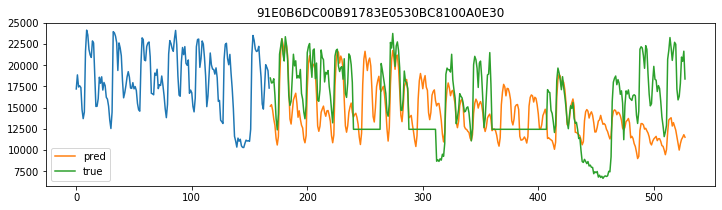

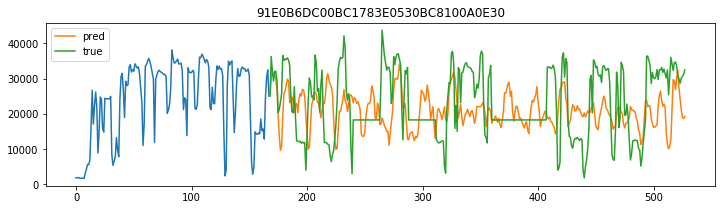

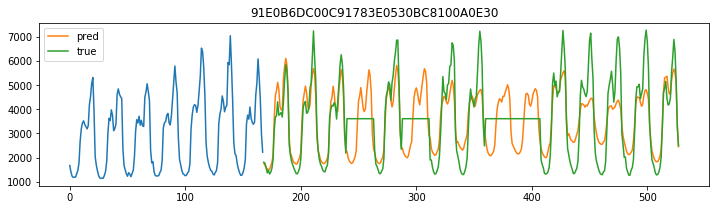

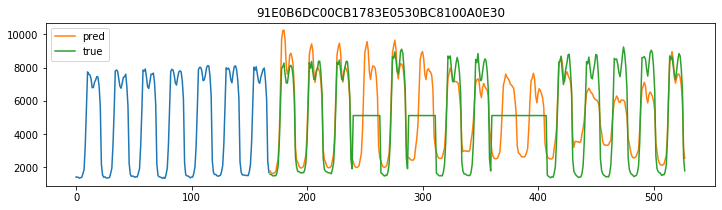

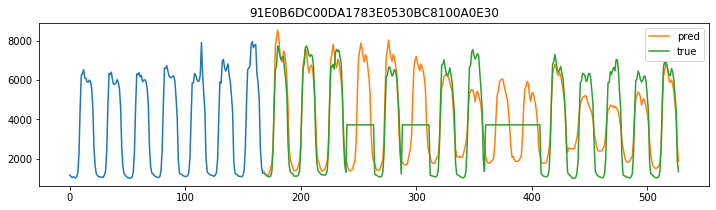

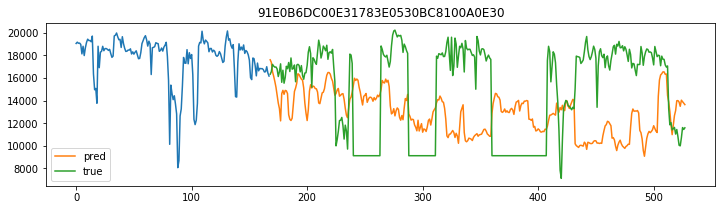

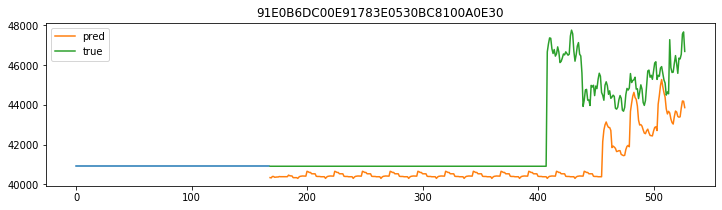

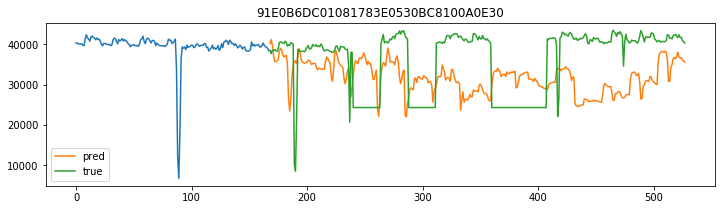

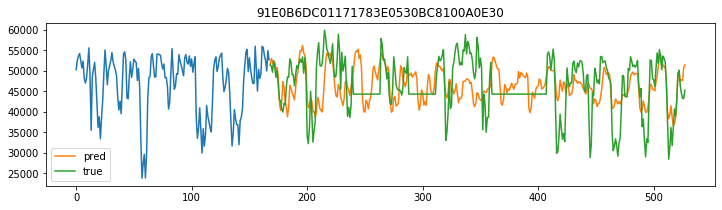

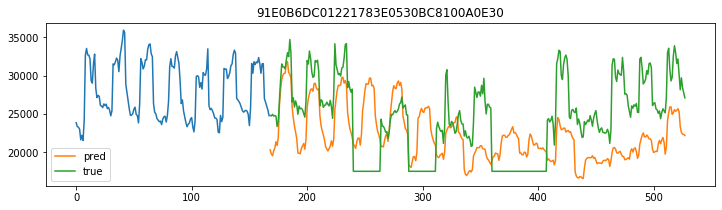

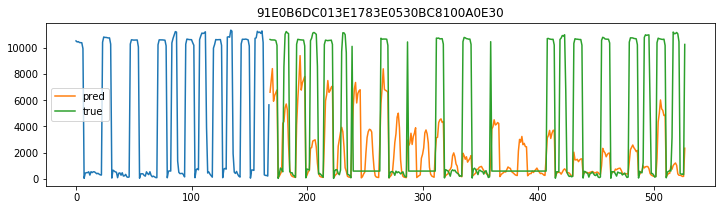

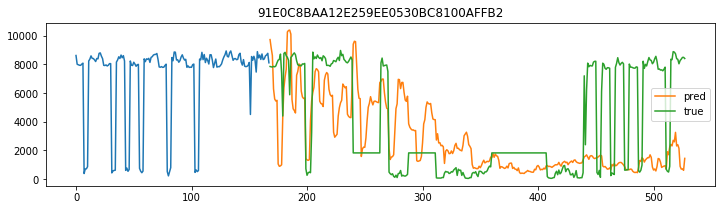

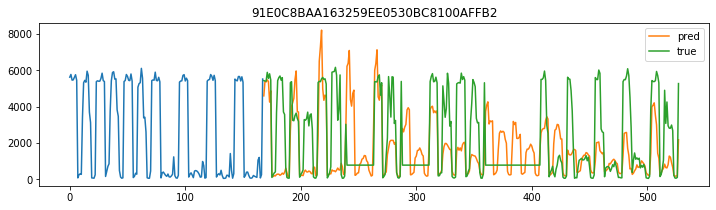

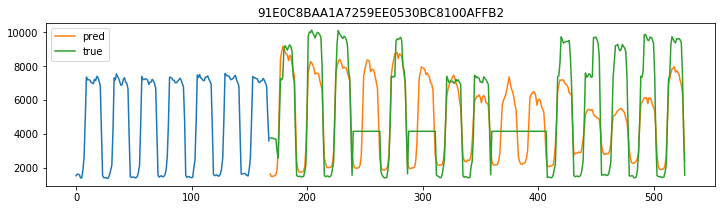

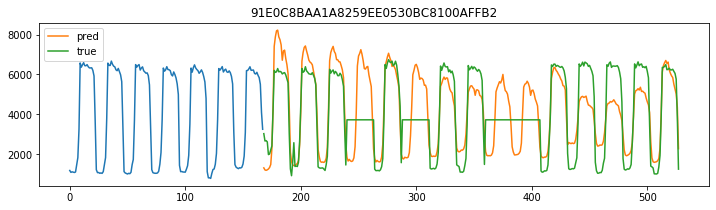

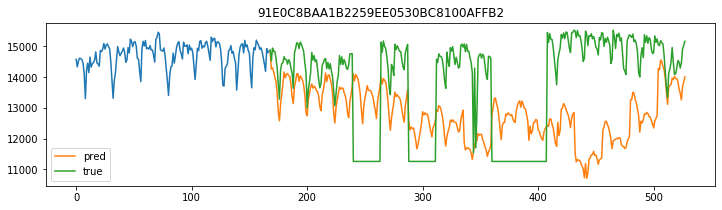

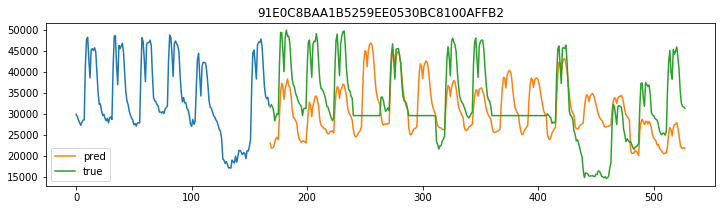

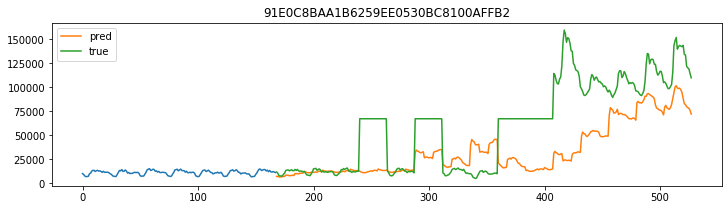

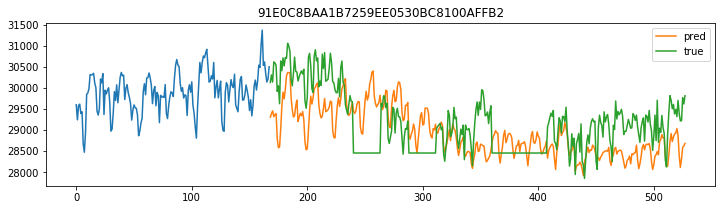

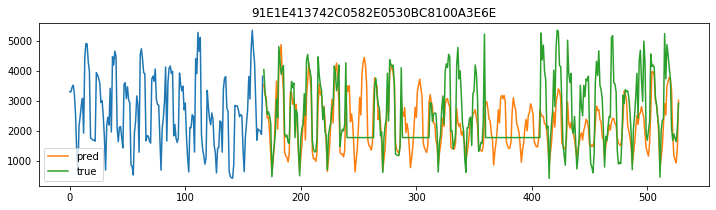

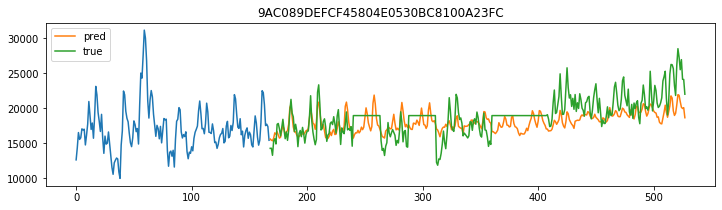

In [13]:
plot(x_true, y_true, y_pred)